In [2]:
import gym

In [25]:
# create a Cartpole environment
# Cartpole is a 2D simulation in which a cart can be accelerated left or right in order to balance a pole places on top of it
# choose to render states as RGB numpy arrays
env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, _ = env.reset(seed=42)  # initialize the env, which returns the first observation
# in this env, an observation consists of the cart's horizontal position, its velocity, the angle of the pole, and its angular velocity
obs

(array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32),
 {})

In [26]:
# get all available environments
gym.envs.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4'])

In [27]:
img = env.render()  # render the current state

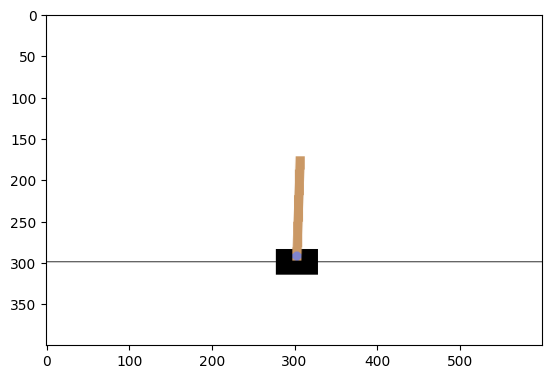

In [28]:
import matplotlib.pyplot as plt
plt.imshow(img)  # plot the current state

In [29]:
# check for possible actions
env.action_space  # possible actions are either the integer 0 (accelerate left) or 1 (accelerate right)

Discrete(2)

In [30]:
# since pole is leaning toward the right (obs[2] > 0), let's accelerate the cart toward the right
# accelerate right once
action = 1
obs, reward, terminated, truncated, info = env.step(action)
print(obs)
print(reward)  # in this case the reward is always one. The goal is to keep the episode running as long as possible
print(terminated)
print(truncated)
print(info)  # no info in this case


[ 0.02727336  0.18847767  0.03625453 -0.26141977]
1.0
False
False
{}


/Users/sebastian/Documents/GitHub/study/study_env/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [40]:
# make a policy that accelerates to the side where the pole tiltint toward
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

# run 500 simulations of maximum 200 steps each. Store the number of steps before the pole fell
totals = []
for episode in range(500):
    episode_rewards = 0
    obs, _ = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        episode_rewards += reward
        if terminated or truncated:
            break
    totals.append(episode_rewards)

In [41]:
import numpy as np
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.18, 9.015963620157304, 24.0, 72.0)

In [43]:
# neural network policy
import tensorflow as tf
from tensorflow import keras

n_inputs = 4  # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid")  # because there are only two possible actions
])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-02 13:23:48.333651: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-02 13:23:48.334295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [42]:
# implement a basic REINFORCE algorithm
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])  # we pass our model a batch with a single instance. It returns the probability of going left
        action = (tf.random.uniform([1, 1]) > left_proba)  # get a random number from 0 to 1 (in a 1x1 tensor) and compare to left_proba to decide the action. 0 means move left. 1 means move right.
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)  # probability of going left (either 0 or 1)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))  # compute mean loss function

    grads = tape.gradient(loss, model.trainable_variables)  # gradient descent on trainable parameters
    obs, reward, terminated, truncated, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, terminated, truncated, grads


In [44]:
# make function that plays multiple episodes

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, terminated, truncated, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if terminated or truncated:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads  # return one list of rewards/grads per episode (with one reward/grad per step)

In [49]:
# apply discount to all the rewards and standardize to get action advantages
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) -2, -1, -1):  # [N-2, N-3, ..., 0]
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(reward, discount_factor) for reward in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]


In [47]:
# example
discount_rewards([10, 0, -50], discount_factor=0.8)
# it returns [10 + 0 * gamma + (-50)*gamma^2, 0 + (-50)*gamma, -50]

array([-22, -40, -50])

In [50]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8)
# return standardizes rewards (mean and std computed over ALL the values)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [51]:
# define some parameters and compile and train the model
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [ ]:
# build and run
for iteration in range(n_iterations):  # training iterations
    # each trianing iteration plays 10 games
    # for each step in each game return all the rewards and gradients
    all_rewards, all_grads = play_multiple_episodes(
        env, 
        n_episodes=n_episodes_per_update, 
        n_max_steps=n_max_steps,
        loss_fn=loss_fn,
        model=model
        )
    # calculate the action advantage for each step in each game
    all_final_rewards = discount_and_normalize_rewards(all_rewards=all_rewards, discount_factor=discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):  # itearte each training variable
        # for each variable compute the weighted mean of the gradients for that variable over all games and steps
        # the weight is the final reward
        mean_grads = tf.reduce_mean([final_reward * all_grads[episode_index][step][var_index] 
                                     for episode_index, final_rewards in enumerate(all_final_rewards) 
                                     for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

# Markov Decision Process

In [52]:
# mock transition probabilities, rewards and possible actions at each state

# the transition probability from s2 to s0 after playing action a1 is at transition_probabilities[2][1][0]
transition_probabilities = [  # shape [s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0 , 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]

# the reward gotten from s2 to s0 after playing action a1 is at rewards[2][1][0]
rewards = [  # shape [s, a, s']
    [[10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [40, 0, 0], [0, 0, 0]]
]

# the possible actions at state s2 are given by possible_actions[2]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [53]:
# initialize the Q values
Q_values = np.full((3, 3), - np.inf)  # -infty for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all actions

In [54]:
gamma = 0.9  # discount factor

for iteration in range(50):  # training iterations
    Q_prev = Q_values.copy()
    for s in range(3):  # iterate over all states
        for a in possible_actions[s]:  # iterate over the possible actions of state s
            Q_values[s, a] = np.sum([
                transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp])) for sp in range(3)  # Q-value iteration algorithm
            ])

In [55]:
# optimal Q-values
Q_values
# for example, when the agent is at state s0 and it chooses action a1, 
# the expected sum of discounted future rewards is approximately 17

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [56]:
# for each state, get the action that has the highest Q-value
np.argmax(Q_values, axis=1)
# this is the optimal policy.
# whenever the agent is in s0, it should choose a0
# whenever the agent is in s1, it should choose a0
# whenever the agent is in s2, it should choose a1

array([0, 0, 1])

# Q-Learning Algorithm

In [57]:
# make an agent explore the environment
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [58]:
# make an exploration policy
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [ ]:
# implement Q-learning with learning rate decay
alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.90  # discount factor
state = 0 # inital state

for iteration in range(10000):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

In [ ]:
env.close()  # free the resources

# Deep Q-Learning

In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import gym

In [2]:
env = gym.make("CartPole-v0", render_mode="rgb_array")
input_shape = [4]  # == env.observation_space.shape number of variables in an observation
n_outputs = 2  # == env.action_space.n  number of possible actions

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



/Users/sebastian/Documents/GitHub/study/study_env/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
2023-03-03 09:36:31.002597: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-03 09:36:31.002691: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
def epsilon_greedy_policy(state, epsilon=0):
    # greedy policy
    # behave randomly with a certain probability, alternatively choose the action with highest Q-value
    if np.random.rand() < epsilon: 
        return np.random.randint(2)
    else: 
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [4]:
# make replay buffer
from collections import deque

replay_buffer = deque(maxlen=2000)

In [5]:
# sample experiences from the buffer
# an experience has a state, the action the agent took, the resulting reward,
# the next state it reached and a boolean with whether the episode ended at the point
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones
    

In [6]:
# play one step
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, terminated, truncated, info = env.step(action)
    done = truncated or terminated
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [7]:
# sample a batch of experiences and apply gradients (i.e. one training step)
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size=batch_size)  # get a batch of experiences
    states, actions, rewards, next_states, dones = experiences  # unpack experiences
    next_Q_values = model.predict(next_states)  # predict Q-value of the posterior state of each experience
    max_next_Q_values = np.max(next_Q_values, axis=1)  # choose the maximum Q value (we assume the agent plays optimally)
    target_Q_values = (rewards + (1 - dones) * discount_factor * max_next_Q_values)  # apply Q-target algorithm

    # the DQN outputs a Q-value for each experienced state-action pair, so we mask out all the suboptimal Q-values
    # E.g. if the first 3 experiences contain actions 1, 1, 0, then the mask will be [[0, 1], [0, 1], [1,0]]
    mask = tf.one_hot(actions, n_outputs)  
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)  # collapse all the zeros (i.e., one predicted Q-value for each experience in the batch)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))  # compute the loss between predicted and target Q-values
    grads = tape.gradient(loss, model.trainable_variables)  # compute gradients
    optimizer.apply_gradients(zip(grads, model.trainable_variables))  # apply gradient

In [8]:
for episode in range(600):  # run multiple episode
    obs, _ = env.reset()
    epsilon = max(1 - episode / 500, 0.01)  # epsilon progressively decreases until 0.01
    for step in range(200):
        obs, reward, done, info = play_one_step(env, obs, epsilon) # take an action and store the experience in the buffer
        if done:
            break
    if episode > 50:
        # start training once there are enough past instances in the buffer
        training_step(batch_size=batch_size)

1/1 [==============================] - 0s 14ms/step


/Users/sebastian/Documents/GitHub/study/study_env/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
2023-03-03 09:36:35.580528: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-03 09:36:35.612408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s